# Idealized examples showing proof of concept

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from wave_tracing_FE import Wave_tracing_FE
from scipy.stats import norm
import cmocean
import xarray as xa

%matplotlib inline

In [2]:
# READ INPUT DATA
ncin = xa.open_dataset('idealized_input.nc')
idt0=15 #22

# Current forcing

In [3]:
X = ncin.x.data
Y = ncin.y.data
nx = len(Y)
ny = len(X)
dx=dy=X[1]-X[0]
nb_wave_rays = 200#550#nx
T = 3000
nt = 1900
wave_period = 10 #s
X0, XN = Y[0], Y[-1] 
Y0, YN = X[0], X[-1]

i_w_side = 'left'
theta0=0

In [4]:
# EDDY
wt_eddy = Wave_tracing_FE(ncin.U[idt0::,:,:], ncin.V[idt0::,:,:], nx, ny, nt,T,dx,dy, wave_period, theta0, nb_wave_rays=nb_wave_rays,
                     domain_X0=X0, domain_XN=XN,
                     domain_Y0=Y0, domain_YN=YN,
                     incoming_wave_side=i_w_side)
wt_eddy.set_initial_condition()
wt_eddy.solve()

/home/trygveh/documents/phd/ocean_wave_tracing/wave_tracing_FE.py:176: RuntimeWarning: overflow encountered in sinh
  n = 0.5 * (1 + (2*k*d)/np.sinh(2*k*d))


In [5]:
# Jet
wt_jet = Wave_tracing_FE(ncin.U_jet[:,:], ncin.V_zero[idt0,:,:], nx, ny, nt,T,dx,dy, wave_period, theta0, nb_wave_rays=nb_wave_rays,
                     domain_X0=X0, domain_XN=XN,
                     domain_Y0=Y0, domain_YN=YN,
                     incoming_wave_side=i_w_side)
wt_jet.set_initial_condition()
wt_jet.solve()

In [6]:
# Opposing jet
wt_jet_o = Wave_tracing_FE(ncin.U_jet[:,:], ncin.V_zero[idt0,:,:], nx, ny, nt,T,dx,dy, wave_period, np.pi, nb_wave_rays=nb_wave_rays,
                     domain_X0=X0, domain_XN=XN,
                     domain_Y0=Y0, domain_YN=YN,
                     incoming_wave_side='right')
wt_jet_o.set_initial_condition()
wt_jet_o.solve()

In [7]:
vorticity = wt_eddy.dvdx-wt_eddy.dudy


In [8]:
#plotting params
fs=15

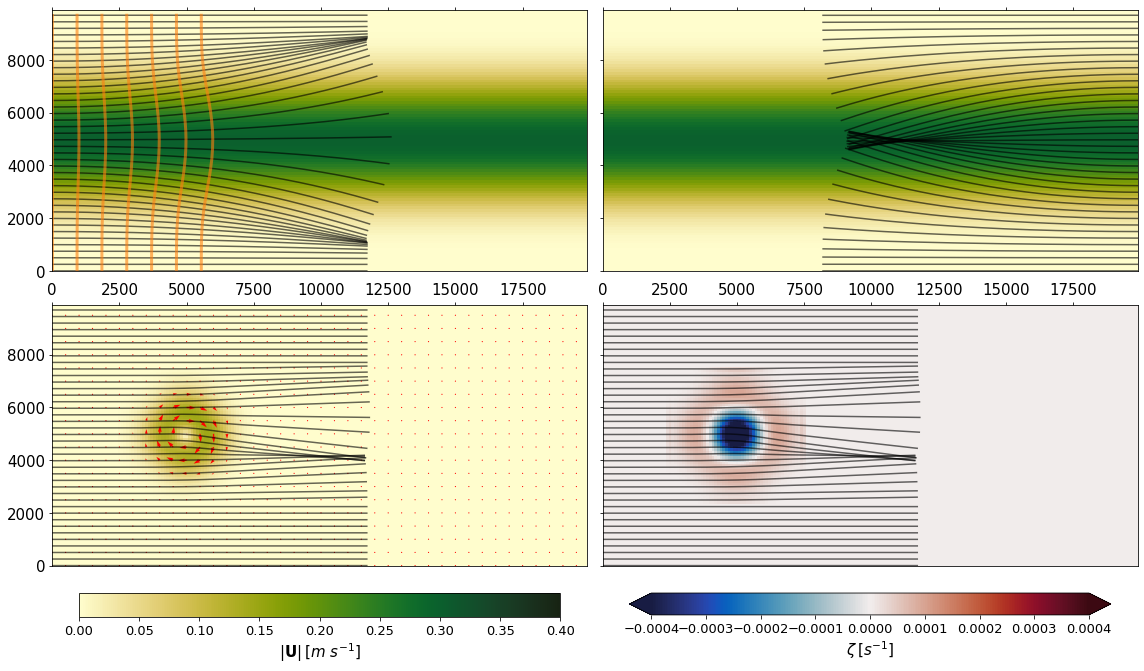

In [10]:
fig,ax = plt.subplots(nrows=2,ncols=2,sharex=True,sharey=True,figsize=(16,10))

cases = [wt_jet, wt_jet_o, wt_eddy, wt_eddy]
s_max = .4

pc=ax[0,0].pcolormesh(wt_jet.x,wt_jet.y,wt_jet.U[0,:,:],shading='auto',cmap=cmocean.cm.speed,vmin=0,vmax=s_max)

ax[0,1].pcolormesh(wt_jet.x,wt_jet.y,wt_jet.U[0,:,:],shading='auto',cmap=cmocean.cm.speed,vmin=0,vmax=s_max)



ax[1,0].pcolormesh(wt_eddy.x,wt_eddy.y,ncin.speed[idt0,:,:],shading='auto',cmap=cmocean.cm.speed,
                   vmin=0,vmax=s_max)

q_step = 5
qu=ax[1,0].quiver(wt_eddy.x[::q_step],wt_eddy.y[::q_step],
                  wt_eddy.U[0,::q_step,::q_step],wt_eddy.V[0,::q_step,::q_step],
                  color='r', scale=8)

pc2=ax[1,1].pcolormesh(wt_eddy.x,wt_eddy.y,vorticity[0,:,:],shading='auto',cmap=cmocean.cm.balance,vmin=-4e-4,vmax=4e-4)

for i,aax in enumerate(ax.flatten()):
    wt =cases[i]
    for i in range(0,wt.nb_wave_rays,5):
        aax.plot(wt.xr[i,:],wt.yr[i,:],'-k',alpha=0.6)
    aax.tick_params(labelsize=fs)
    aax.xaxis.tick_top()

ax[0,0].set_xlim([X0,XN])
ax[0,0].set_ylim([Y0,YN])

idts = np.arange(0,1000,150)
ax[0,0].plot(wt_jet.xr[::5,idts],wt_jet.yr[::5,idts],c='tab:orange',lw=3,alpha=0.6)

fig.tight_layout()

cb1=fig.colorbar(pc, ax=[ax[0,0],ax[1,0]], orientation='horizontal',shrink=0.9, pad=0.04)
cb2=fig.colorbar(pc2, ax=[ax[0,1],ax[1,1]], orientation='horizontal',shrink=0.9, extend='both', pad=0.04)
cb1.set_label(r'$|\mathbf{U}| \: [m~s^{-1}]$',fontsize=fs)
cb2.set_label(r'$\zeta \: [s^{-1}] $',fontsize=fs)
cb1.ax.tick_params(labelsize=fs-2) 
cb2.ax.tick_params(labelsize=fs-2) 

#fig.savefig('/home/trygveh/documents/phd/papers/wave_ray_tracing/figures/current_refraction_examples.png',dpi=170)


# Depth refraction

In [10]:
# constant slope bottom
wt_cs = Wave_tracing_FE(ncin.U_zero[idt0,:,:], ncin.V_zero[idt0,:,:], nx, ny, nt,T,dx,dy, wave_period, 
                        0, nb_wave_rays=nb_wave_rays,
                        domain_X0=X0, domain_XN=XN,
                        domain_Y0=Y0, domain_YN=YN,
                        incoming_wave_side='left',d=ncin.bathymetry_1dy_slope.data)
wt_cs.set_initial_condition()
wt_cs.solve()

/home/trygveh/documents/phd/ocean_wave_tracing/wave_tracing_FE.py:432: RuntimeWarning: invalid value encountered in remainder
  theta[:,n+1] = theta[:,n+1]%(2*np.pi)
/home/trygveh/documents/phd/ocean_wave_tracing/wave_tracing_FE.py:401: RuntimeWarning: invalid value encountered in remainder
  phi = (theta[:,n]-(0.5*np.pi))%(2*np.pi)


In [11]:
# constant slope bottom lower right
wt_cs_lr = Wave_tracing_FE(ncin.U_zero[idt0,:,:], ncin.V_zero[idt0,:,:], nx, ny, nt,T,dx,dy, wave_period, 
                        np.pi-0.3, nb_wave_rays=nb_wave_rays,
                        domain_X0=X0, domain_XN=XN,
                        domain_Y0=Y0, domain_YN=YN,
                        incoming_wave_side='right',d=ncin.bathymetry_1dy_slope.data)
wt_cs_lr.set_initial_condition()
wt_cs_lr.solve()

In [12]:
# complex bottom left
wt_cb_l = Wave_tracing_FE(ncin.U_zero[idt0,:,:], ncin.V_zero[idt0,:,:], nx, ny, nt,T,dx,dy, wave_period, 
                        0, nb_wave_rays=nb_wave_rays,
                        domain_X0=X0, domain_XN=XN,
                        domain_Y0=Y0, domain_YN=YN,
                        incoming_wave_side='left',d=ncin.bathymetry_bm.data)
wt_cb_l.set_initial_condition()
wt_cb_l.solve()

In [13]:
# complex bottom bottom
wt_cb_b = Wave_tracing_FE(ncin.U_zero[idt0,:,:], ncin.V_zero[idt0,:,:], nx, ny, nt,T,dx,dy, wave_period, 
                        1, nb_wave_rays=nb_wave_rays,
                        domain_X0=X0, domain_XN=XN,
                        domain_Y0=Y0, domain_YN=YN,
                        incoming_wave_side='bottom',d=ncin.bathymetry_bm.data)
wt_cb_b.set_initial_condition()
wt_cb_b.solve()

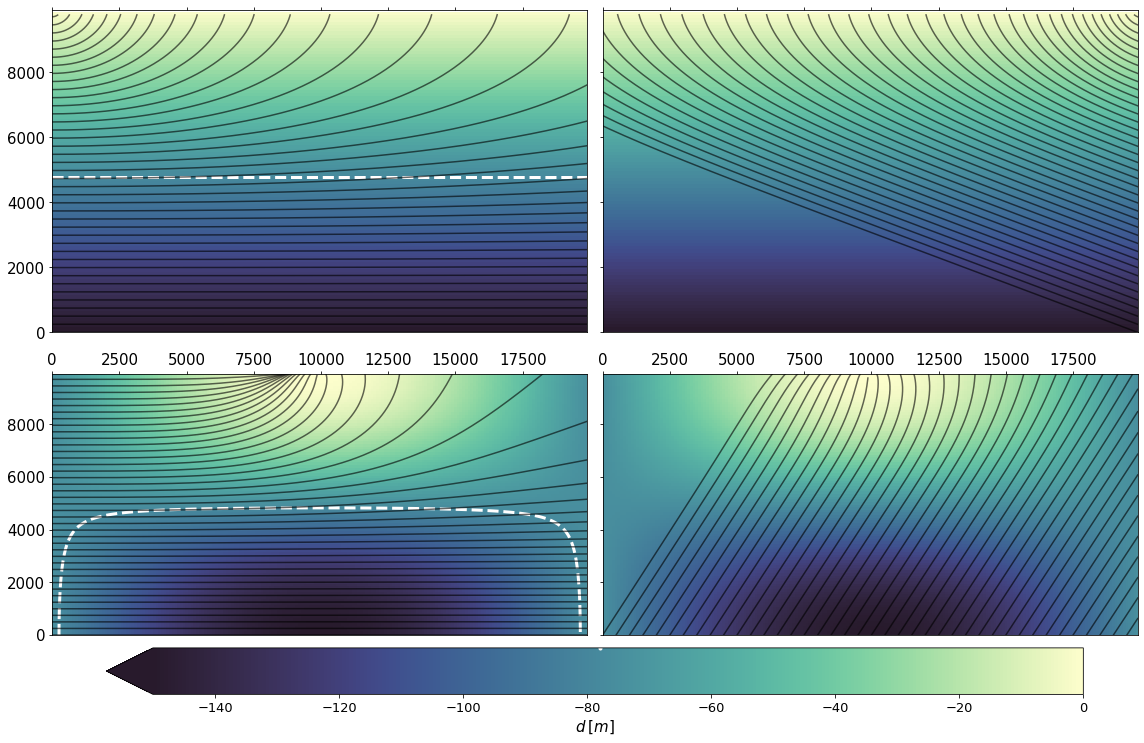

In [15]:
fig2,ax2 = plt.subplots(nrows=2,ncols=2,sharex=True,sharey=True,figsize=(16,10))

cases_b = [wt_cs, wt_cs_lr, wt_cb_l, wt_cb_b]
d_max = -150

pc_d=ax2[0,0].pcolormesh(wt_cs.x,wt_cs.y,-wt_cs.d[:,:],shading='auto',cmap=cmocean.cm.deep_r,vmin=d_max,vmax=0)


ax2[0,1].pcolormesh(wt_cs_lr.x, wt_cs_lr.y,-wt_cs_lr.d[:,:],shading='auto',cmap=cmocean.cm.deep_r,vmin=d_max,vmax=0)

ax2[1,0].pcolormesh(wt_cb_l.x, wt_cb_l.y,-wt_cb_l.d[:,:],shading='auto',cmap=cmocean.cm.deep_r,vmin=d_max,vmax=0)

ax2[1,1].pcolormesh(wt_cb_l.x, wt_cb_l.y,-wt_cb_l.d[:,:],shading='auto',cmap=cmocean.cm.deep_r,vmin=d_max,vmax=0)


for i,aax in enumerate(ax2.flatten()):
    wt =cases_b[i]
    for i in range(0,wt.nb_wave_rays,5):
        aax.plot(wt.xr[i,:],wt.yr[i,:],'-k',alpha=0.6)
    aax.tick_params(labelsize=fs)
    aax.xaxis.tick_top()

ax2[0,0].set_xlim([X0,XN])
ax2[0,0].set_ylim([Y0,YN])

ax2[0,0].contour(wt_cs.x,wt_cs.y,-wt_cs.d[:,:],[-156/2], colors='w', linewidths=3 )
ax2[1,0].contour(wt_cb_l.x,wt_cb_l.y,-wt_cb_l.d[:,:],[-156/2], colors='w', linewidths=3 )


fig2.tight_layout()

cb1_d=fig2.colorbar(pc_d, ax=[ax2[1,0],ax2[1,1]], orientation='horizontal',shrink=0.9, pad=0.04, extend='min')

cb1_d.set_label(r'$d \: [m]$',fontsize=fs)

cb1_d.ax.tick_params(labelsize=fs-2) 
#cb1_d.ax.plot([1],[-156/2],'w')
#cb1_d.ax.plot([-40],[-0.5],'w')
cb1_d.ax.plot(-156/2,0.1, 'w.')

#fig2.savefig('/home/trygveh/documents/phd/papers/wave_ray_tracing/figures/depth_refraction_examples.png',dpi=170)


# Comparing eddy with and without bathymetry

In [16]:
# EDDY
wt_eddy_b = Wave_tracing_FE(ncin.U[idt0::,:,:], ncin.V[idt0::,:,:], nx, ny, nt,T,dx,dy, wave_period, theta0, nb_wave_rays=nb_wave_rays,
                     domain_X0=X0, domain_XN=XN,
                     domain_Y0=Y0, domain_YN=YN,
                     incoming_wave_side=i_w_side, d=ncin.bathymetry_bm.data)
wt_eddy_b.set_initial_condition()
wt_eddy_b.solve()

/home/trygveh/documents/phd/ocean_wave_tracing/wave_tracing_FE.py:432: RuntimeWarning: invalid value encountered in remainder
  theta[:,n+1] = theta[:,n+1]%(2*np.pi)
/home/trygveh/documents/phd/ocean_wave_tracing/wave_tracing_FE.py:401: RuntimeWarning: invalid value encountered in remainder
  phi = (theta[:,n]-(0.5*np.pi))%(2*np.pi)


In [17]:
xx_eddy,yy_eddy,hm_eddy = wt_eddy.ray_density(5,5)
xx_eddy_b,yy_eddy_b,hm_eddy_b = wt_eddy_b.ray_density(5,5)

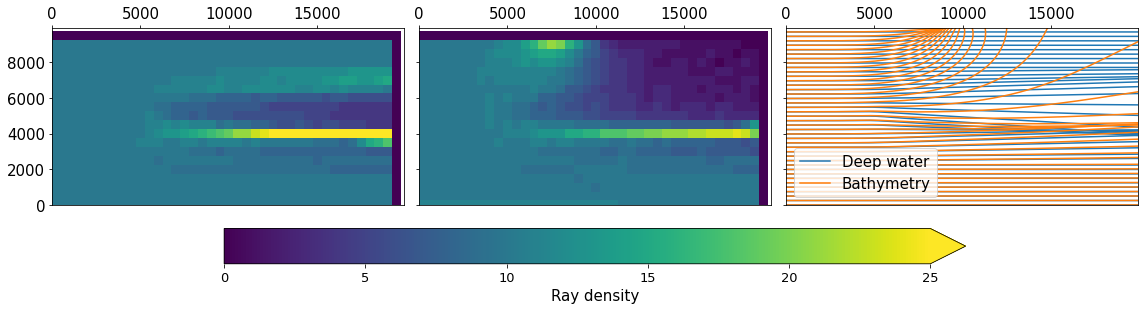

In [18]:
fig3, ax3 = plt.subplots(ncols=3,sharex=True,sharey=True,figsize=(16,4))


pc3 = ax3[0].pcolormesh(xx_eddy,yy_eddy, hm_eddy, vmin=0,vmax=25,shading='auto')
ax3[1].pcolormesh(xx_eddy_b,yy_eddy_b, hm_eddy_b, vmin=0,vmax=25,shading='auto')

for i in range(0,wt_eddy.nb_wave_rays,5):
    if i == 0:
        ax3[2].plot(wt_eddy.xr[i,:],wt_eddy.yr[i,:],c='tab:blue',alpha=1, label='Deep water')
    else:
        ax3[2].plot(wt_eddy.xr[i,:],wt_eddy.yr[i,:],c='tab:blue',alpha=1)
    
for i in range(0,wt_eddy_b.nb_wave_rays,5):
    if i ==0:
        ax3[2].plot(wt_eddy_b.xr[i,:],wt_eddy_b.yr[i,:],c='tab:orange',alpha=1, label='Bathymetry')
    else:
        ax3[2].plot(wt_eddy_b.xr[i,:],wt_eddy_b.yr[i,:],c='tab:orange',alpha=1)
ax3[2].legend(fontsize=fs,loc='lower left')
ax3[0].set_xlim([X0,XN])
ax3[0].set_ylim([Y0,YN])

for i,aax in enumerate(ax3):    
    aax.tick_params(labelsize=fs)
    aax.xaxis.tick_top()

fig3.tight_layout()


cb3=fig3.colorbar(pc3, ax=[ax3], orientation='horizontal',shrink=0.9, pad=0.10, extend='max')

cb3.set_label('Ray density',fontsize=fs)

cb3.ax.tick_params(labelsize=fs-2) 
#fig3.savefig('/home/trygveh/documents/phd/papers/wave_ray_tracing/figures/depth_and_current_refraction.png',dpi=170)